In [460]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [461]:
import os
os.chdir('../Credit')
index_col = 'index'

In [462]:
train=pd.read_csv('train.csv', index_col=index_col)
test=pd.read_csv('test.csv', index_col=index_col)
submission=pd.read_csv('sample_submission.csv', index_col=index_col)

In [463]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [464]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
index,,,,,,,,,,,,,,,,,,
26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [465]:
print(f"train.shape : {train.shape}")
print(f"test.shape : {test.shape}")
train.info()

train.shape : (26457, 19)
test.shape : (10000, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17 

In [466]:
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [467]:
print('edu_type 종류 : ',list(train.edu_type.unique()))
display(train[['edu_type']].head())
edu_order = {
    'Lower secondary' : 0, # 중학교 미만
    'Secondary / secondary special' : 1, #중학교
    'Incomplete higher' : 2, # 고등학교 중퇴
    'Higher education' : 3, # 고등학교 졸업
     'Academic degree' : 4 # 학사 이상
}
train.edu_type = train.edu_type.map(edu_order)
test.edu_type = test.edu_type.map(edu_order)
display(train[['edu_type']].head())
display(test[['edu_type']].head())

edu_type 종류 :  ['Higher education', 'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']


,edu_type
index,
0,Higher education
1,Secondary / secondary special
2,Higher education
3,Secondary / secondary special
4,Higher education


,edu_type
index,
0,3
1,1
2,3
3,1
4,3


,edu_type
index,
26457,1
26458,3
26459,1
26460,1
26461,3


In [468]:
tt = train.loc[train[train.DAYS_EMPLOYED > 0].index]
ttt = train.loc[train[train.DAYS_EMPLOYED < 0].index]

In [522]:
# train[tt['occyp_type']] = 'No Job'
#train.loc[ttt[ttt.occyp_type]]
copied_train = train.copy()
copied_train.loc[(copied_train['DAYS_EMPLOYED'] > 0), 'occyp_type'] = 'No Job'


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
14,F,N,Y,0,157500.0,Pensioner,1,Single / not married,House / apartment,-22922,365243,1,0,1,0,No Job,1.0,-41.0,2.0
18,F,N,Y,0,216000.0,Pensioner,1,Married,House / apartment,-23113,365243,1,0,0,0,No Job,2.0,-37.0,2.0
21,F,N,N,0,157500.0,Pensioner,1,Married,House / apartment,-21253,365243,1,0,1,0,No Job,2.0,-7.0,2.0
24,F,N,N,0,202500.0,Pensioner,1,Single / not married,House / apartment,-22361,365243,1,0,1,0,No Job,1.0,-5.0,2.0
46,F,N,N,0,135000.0,Pensioner,1,Widow,House / apartment,-21100,365243,1,0,1,0,No Job,1.0,-24.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,F,N,Y,0,225000.0,Pensioner,1,Widow,House / apartment,-21151,365243,1,0,0,1,No Job,1.0,-60.0,1.0
26432,F,Y,Y,0,72000.0,Pensioner,1,Married,House / apartment,-22314,365243,1,0,1,0,No Job,2.0,-17.0,1.0
26439,F,N,Y,0,67500.0,Pensioner,1,Married,House / apartment,-19238,365243,1,0,0,0,No Job,2.0,-57.0,2.0


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,


In [414]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         26457 non-null  object
 1   car            26457 non-null  object
 2   reality        26457 non-null  object
 3   child_num      26457 non-null  object
 4   income_total   26457 non-null  object
 5   income_type    26457 non-null  object
 6   edu_type       26457 non-null  object
 7   family_type    26457 non-null  object
 8   house_type     26457 non-null  object
 9   DAYS_BIRTH     26457 non-null  object
 10  DAYS_EMPLOYED  26457 non-null  object
 11  FLAG_MOBIL     26457 non-null  object
 12  work_phone     26457 non-null  object
 13  phone          26457 non-null  object
 14  email          26457 non-null  object
 15  occyp_type     18286 non-null  object
 16  family_size    26457 non-null  object
 17  begin_month    26457 non-null  object
 18  credit         26457 non-n

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,3,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,1,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,3,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,1,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,3,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [384]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      


print("Get Job or not : ")

#train = train.drop('occyp_type', axis=1)
#test = test.drop('occyp_type', axis=1)
#train.loc[train['occyp_type'] == 'No job', 'occyp_type']= 0
#test.loc[test['occyp_type'] == 'No job', 'occyp_type']= 0
#train.loc[train['occyp_type'] != 0, 'occyp_type']= 1
#test.loc[test['occyp_type'] != 0, 'occyp_type']= 1
print(train['occyp_type'].value_counts())
print("-----------")

print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0         13915
1          8104
No Job     4438
Name: gender, dtype: int64
--------------
Having a car or not : 
0         12888
1          9131
No Job     4438
Name: car, dtype: int64
--------------
Having house reality or not: 
1         14385
0          7634
No Job     4438
Name: reality, dtype: int64
--------------
Get Job or not : 
Laborers                 4512
No Job                   4438
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64
-----------
Having a phone or not: 
0         15508

In [385]:
train['occyp_type']

index
0                   NaN
1              Laborers
2              Managers
3           Sales staff
4              Managers
              ...      
26452        Core staff
26453               NaN
26454        Core staff
26455          Laborers
26456    Security staff
Name: occyp_type, Length: 26457, dtype: object

<AxesSubplot:>

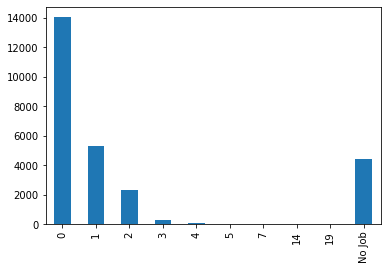

In [386]:
train['child_num'].value_counts(sort=False).plot.bar()

In [387]:
import numpy as np
columns = ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','family_size','begin_month']
candidate = ['income_total', 'DAYS_EMPLOYED', 'family_size']
for cand in candidate :
    train[cand] = ((train[cand] - min(train[cand]) / min(train[cand]) - min(train[cand])))
    
plt.figure(figsize = (20,15))
for i in range(5):
    plt.subplot(3,2,i+1)
    sns.distplot(train[columns[i]])
plt.show()

TypeError: '<' not supported between instances of 'str' and 'float'

In [ ]:
train.loc[data['child_num']>=5, 'child_num'] = 5


In [919]:
#train['income_total'] = train['income_total'].astype(object)
#train['income_total'] = train['income_total']/10000 
#test['income_total'] = test['income_total']/10000
##############################################################3
#print(train['income_total'].value_counts(bins=10,sort=False))
#train['income_total'].plot(kind='hist',bins=50,density=True)

In [920]:
#count, bin_dividers =np.histogram(train['income_total'], bins=7)
#bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
#train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
#test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [925]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())
print(train['occyp_type'].unique())

[0 4 2 1 3]
[3 1 2 0 4]
[1 0 2 3 4]
[2 1 5 0 4 3]
[12  8 10 15  6  3  4 11  0 14 17  1 13  2 16  5  7  9 18]


In [922]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
#train['edu_type']=label_encoder.fit_transform(train['edu_type'])
#test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])
########################################################################
train['occyp_type']=label_encoder.fit_transform(train['occyp_type'])
test['occyp_type']=label_encoder.transform(test['occyp_type'])

In [923]:
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [924]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [895]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,145,0,3,1,2,-13899,11003.0,1,0,0,0,0,0.0,-6.0,1.0
1,0,0,1,1,165,0,1,0,1,-11380,14172.0,1,0,0,1,1,1.0,-5.0,1.0
2,1,1,1,0,214,4,3,1,1,-19087,11278.0,1,0,1,0,1,0.0,-22.0,2.0
3,0,0,1,0,145,0,1,1,1,-15088,13620.0,1,0,1,0,1,0.0,-37.0,0.0
4,0,1,1,0,111,2,3,1,1,-15037,13607.0,1,0,0,0,1,0.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,156,2,1,1,1,-12079,13728.0,1,0,0,0,1,2.0,-2.0,1.0
26453,0,0,1,1,133,4,3,2,1,-15291,13237.0,1,0,0,0,0,4.0,-47.0,2.0
26454,0,1,0,0,181,4,1,0,5,-10082,13697.0,1,0,0,0,1,0.0,-25.0,2.0


In [896]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
index,,,,,,,,,,,,,,,,,,
26457,1,1,0,0,61,1,1,0,1,-21990,365243,1,0,1,0,0,2.0,-60.0
26458,0,0,1,0,82,2,3,1,1,-18964,-8671,1,0,1,0,1,2.0,-36.0
26459,0,0,1,0,34,4,1,1,1,-15887,-217,1,1,1,0,1,2.0,-40.0
26460,1,1,0,0,61,0,1,1,1,-19270,-2531,1,1,0,0,1,2.0,-41.0
26461,0,1,1,0,130,2,3,1,1,-17822,-9385,1,1,0,0,1,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,0,1,1,0,121,4,2,1,1,-18593,-5434,1,1,1,0,1,2.0,-19.0
36453,1,1,1,0,121,4,1,0,1,-10886,-1315,1,1,0,0,1,2.0,-34.0
36454,0,0,1,0,152,4,1,1,1,-21016,-14018,1,0,0,0,1,2.0,-55.0


In [898]:
train.loc[(train['family_size']-train['child_num']) < 0, 'family_size'] = 4 

#train.loc[train['index']==14900]

In [899]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test
print(f"train_x.shape : {train_x.shape}")
print(f"train_y.shape : {train_y.shape}")
print(f"test.shape : {test_x.shape}")
train_x.info()

train_x.shape : (26457, 18)
train_y.shape : (26457, 1)
test.shape : (10000, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  int64  
 1   car            26457 non-null  int64  
 2   reality        26457 non-null  int64  
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  int64  
 5   income_type    26457 non-null  int64  
 6   edu_type       26457 non-null  int64  
 7   family_type    26457 non-null  int64  
 8   house_type     26457 non-null  int64  
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  float64
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     26457 non-null  int64  
 16  family_size   

In [900]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=12)

#xgb_mod = XGBClassifier()
#xgb_param_grid = {
#    'n_estimators' : [500,1000,1500,1800],
#    'learning_rate' : [0.01, 0.05, 0.1, 0,2],
#    'max_depth' : [3,4,6,8],
#}

#xgb_grid = GridSearchCV(xgb_mod, param_grid = xgb_param_grid, scoring="f1", n_jobs= -1, verbose = 1)
#xgb_grid.fit(X_train, Y_train)

In [902]:
print("Train set : ")
print(X_train.shape)
print(Y_train.shape)
print("===============")
print("Validation set : ")
print(X_val.shape)
print(Y_val.shape)

xgb_mod = XGBClassifier(
   booster='gbtree',
    colsample_bytree=0.5,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=500,   
    subsample=0.9,
    random_state=12,
    eval_metric = 'logloss',
    objective = 'multi:softprob',
   
) 

#XGboost
clf = xgb_mod.fit(X_train, Y_train)
y_pred = xgb_mod.predict_proba(X_val)

#랜덤 포레스트
#clf = RandomForestClassifier()
#clf.fit(X_train, Y_train)
#y_pred = clf.predict_proba(X_val)

print(f"log_loss : {log_loss(to_categorical(Y_val['credit']), y_pred)}")

Train set : 
(19842, 18)
(19842, 1)
Validation set : 
(6615, 18)
(6615, 1)
log_loss : 0.738263505856624


In [749]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):  
    folds=StratifiedKFold(n_splits=2, shuffle=True, random_state=12)
    outcomes=[]
    sub=np.zeros((test_x.shape[0],3))
   
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x,train_y)):
        #X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        #Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, Y_train)
        
        predictions = clf.predict_proba(X_val)
        
        logloss= log_loss(to_categorical(Y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : log_loss : {logloss}")
        
        sub+=clf.predict_proba(test_x)
        
    mean_outcome = np.mean(outcomes)

    print("Mean : {}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : log_loss : 0.7345876474524774
FOLD 1 : log_loss : 0.7345876474524774
Mean : 0.7345876474524774


In [753]:
submission

,0,1,2
index,,,
26457,0,0,0
26458,0,0,0
26459,0,0,0
26460,0,0,0
26461,0,0,0
...,...,...,...
36452,0,0,0
36453,0,0,0
36454,0,0,0


In [757]:
submission.loc[:,:]=my_submission

In [758]:
submission

,0,1,2
index,,,
26457,0.027077,0.057730,0.915194
26458,0.231401,0.122179,0.646421
26459,0.126466,0.138267,0.735268
26460,0.172699,0.076292,0.751009
26461,0.059469,0.077393,0.863138
...,...,...,...
36452,0.117179,0.364319,0.518502
36453,0.127269,0.387020,0.485711
36454,0.030452,0.058781,0.910767


In [760]:
submission.to_csv('xgboost_submission.csv')